## 微博评论区情绪分值评估与分析--基于snowNLP与seaborn的大数据分析项目
随着互联网的快速发展，微博等社交平台成为了社会舆论与广告宣传的主要传播手段之一。本项目通过爬虫技术、大数据分析、自然语言模型等技术为用户分析给定微博的评论所体现的情绪导向、关键词以及受众特点等，以更好的帮助用户分析其微博的主要受众，造成的社会舆论影响导向，以及社会舆论情绪倾向随时间变化的趋势等。
本项目具体的一些应用方向如下：

#### 社会研究：
通过分析用户的情绪分布，可以研究社会心理学、情感学等方面的现象。例如，可以关注不同时间用户情绪的变化，了解社会舆论的走向。

#### 品牌或产品营销：
对用户情绪的了解可能有助于企业识别用户对其品牌或产品的态度。这有助于改进市场策略，提高用户满意度。

#### 舆情监测：
实时监测微博用户的情绪，可以帮助政府、组织或个人了解公众对特定话题或事件的反应，从而采取相应的行动。

#### 社交媒体营销：
分析情绪与性别、粉丝数量之间的关系，可以帮助社交媒体营销人员更好地了解目标受众，制定更有针对性的营销策略。

#### 用户体验改进：
一些网站或应用程序开发者可以通过将产品的博客对应的情绪分布与用户体验关联起来，这将有助于改进其产品，以提高用户满意度。

In [203]:
TARGET_ID='4950695835600474'

以下是需要用的一些库函数

In [204]:
import os
import requests
import pandas as pd
import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

以下代码用于使用我们收集到的微博评论情感分析数据集来重新训练snowNLP自然语言模型。由于我们已经巡练并且保存过了，所以可以注释掉。初次使用时需要使用这段代码进行训练。

In [205]:
# from snownlp import SnowNLP
# from snownlp import sentiment
# sentiment.train('sample.negative.txt', 'sample.postive.txt')
# sentiment.save('sentiment.marshal')

以下是获取评论对应的情绪得分的函数。需要注意的是如果评论为空的话调用snowNLP的情绪得分函数会报错，这时我们考虑采用返回默认的情绪分值0.5（中立）

In [206]:
from snownlp import SnowNLP
from snownlp import sentiment
sentiment.load('sentiment.marshal')
def getScore(comment):
    try:
        return SnowNLP(comment).sentiments
    except:
        return 0.5

以下是爬虫函数所需的一些处理数据的函数以及变量

In [207]:
def trans_time(v_str):
    """转换GMT时间为标准格式"""
    GMT_FORMAT = '%a %b %d %H:%M:%S +0800 %Y'
    timeArray = datetime.datetime.strptime(v_str, GMT_FORMAT)
    ret_time = timeArray.strftime("%Y-%m-%d %H:%M:%S")
    return ret_time
def tran_num(number):#微博对于粉丝量超过一万的用户会以数字+“万”的形式来表示粉丝量，
    length=len(number)
    if(number[len(number)-1]=='万'):
        return float(number[0:length-1])*10000
    else:
        return int(number)
def tran_location(location):#微博返回的location在最前面会自带“来自”两个字，我们考虑将其过滤掉
    return location[2:]
def tran_gender(gender_tag):#微博使用m f来表示男性与女性，我们将其进行转换来更直接的体现
    """转换性别"""
    if gender_tag == 'm':
        return '男'
    elif gender_tag == 'f':
        return '女'
    else:
        return '未知'
page_list = []  # 评论页码
id_list = []  # 评论id
text_list = []  # 评论内容
time_list = []  # 评论时间
like_count_list = []  # 评论点赞数
source_list = []  # 评论者IP归属地
user_name_list = []  # 评论者姓名
user_id_list = []  # 评论者id
user_gender_list = []  # 评论者性别
follow_count_list = []  # 评论者关注数
followers_count_list = []  # 评论者粉丝数
text_score_list=[] # 情感分数数值
male_score_list=[] # 男性情感分数数值
female_score_list=[] # 女性情感分数数值
max_id = '0'

以下是爬虫函数，我们将爬虫结果保存到csv中，让用户可以直观的观察数据，也可以让用户直接使用csv数据来进行个性化的数据处理

In [208]:
def get_comments(weibo_id, v_comment_file, v_max_page):
    
    #weibo_id: 微博id
    #param v_comment_file: 保存文件名
    #param v_max_page: 最大页数
    for page in range(1, v_max_page + 1):
        print('开始爬取第{}页'.format(page))
        if page == 1:  # 第一页，没有max_id参数
            url = 'https://m.weibo.cn/comments/hotflow?id={}&mid={}&max_id_type=0'.format(weibo_id, weibo_id)
        else:  # 非第一页，需要max_id参数
            if str(max_id) == '0':  # 如果发现max_id为0，说明没有下一页了，break结束循环
                print('max_id is 0, break now')
                break
            url = 'https://m.weibo.cn/comments/hotflow?id={}&mid={}&max_id_type=0&max_id={}'.format(weibo_id,
                                                                                                    weibo_id,
                                                                                                    max_id)
        # 发送请求
        headers = {
            "user-agent": 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36',
            # 如果cookie失效，会返回-100响应码,如果发生，请将cookie替换为您的微博cookie
            "cookie": "__bid_n=18851ae395341de84d4207; FPTOKEN=cD0LoRavQ32IdPHxPjaTWu9ODTl9ef1avAKk8aV4DZCRZL7rEywpodCZKser2D/wdqbZZ3icjd0PaYjTWUgpIT9zjdKVaZFbMP9oL4kEVd92u4YemfZ8ch9p9OF5QxcI6tPuCFIibANHBHwie7ybz8Bw7qZkp6vCxPzLjIfqZAk3D/iDXsVrKrj5Hqq6mWv5P7hUpVl4NMw6e1F0l0k87aNa1i/TSsQDl+Jmc2z+awCnu1aKwHo78brSiBASXBtzAmgYOIuUGDko/S9/F0V6BNsqEW9gYr6vh+7j7DDz5hsKs0q8pNvnPn7mW/kWP8bYnSY0SX209rxLCB/Vjxs9J2MlXo8sie7m3ptZ0IHzvBh2a7Yd3aoXnlM9F4gCTdVobpCiZRHarQwrOU+SFciNmQ==|vdTCRNhVxZRPCABl4U8wFcMHHZeh3M6TZqgCmsNuL9E=|10|e76ac732782d24c728e5893bc5f8e292; WEIBOCN_FROM=1110006030; BAIDU_SSP_lcr=https://link.csdn.net/; SUB=_2A25IY1xXDeRhGeBH4lAS8C3FzjqIHXVrAdGfrDV6PUJbkdANLRWskW1NQYkaXJoHbyTZlVQ1a7_TyQv7lQ5t6rXp; _T_WM=40651199420; MLOGIN=1; XSRF-TOKEN=429b49; M_WEIBOCN_PARAMS=luicode%3D20000174%26uicode%3D20000174",
            "accept": "application/json, text/plain, */*",
            "accept-encoding": "gzip, deflate, br",
            "accept-language": "zh-CN,zh;q=0.9,en-US;q=0.8,en;q=0.7",
            "referer": "https://m.weibo.cn/detail/{}".format(weibo_id),
            "x-requested-with": "XMLHttpRequest",
            "mweibo-pwa": '1',
        }
        r = requests.get(url, headers=headers)  # 发送请求
        print(r.status_code)  # 查看响应码
        try:
            max_id = r.json()['data']['max_id']  # 获取max_id给下页请求用
            datas = r.json()['data']['data']
        except Exception as e:
            print('excepted: ' + str(e))
            break
        for data in datas:
            page_list.append(page)
            id_list.append(data['id'])
            dr = re.compile(r'<[^>]+>', re.S)  # 用正则表达式清洗评论数据
            text2 = dr.sub('', data['text'])
            text_list.append(text2)  # 评论内容
            time_list.append(trans_time(v_str=data['created_at']))  # 评论时间
            like_count_list.append(data['like_count'])  # 评论点赞数
            source_list.append(tran_location(data['source']))  # 评论者IP归属地
            user_name_list.append(data['user']['screen_name'])  # 评论者姓名
            user_id_list.append(data['user']['id'])  # 评论者id
            user_gender_list.append(tran_gender(data['user']['gender']))  # 评论者性别
            follow_count_list.append(data['user']['follow_count'])  # 评论者关注数
            followers_count_list.append(tran_num(data['user']['followers_count']))  # 评论者粉丝数
            text_score_list.append(getScore(text2)) # 评论情绪分值
            if(data['user']['gender']=='m'):
                male_score_list.append(getScore(text2)) # 男性评论情绪分值
            else:
                female_score_list.append(getScore(text2)) # 女性评论情绪分值
    df = pd.DataFrame(
        {
            'max_id': max_id,
            '微博id': [weibo_id] * len(time_list),
            '评论页码': page_list,
            '评论id': id_list,
            '评论时间': time_list,
            '评论点赞数': like_count_list,
            '评论者IP归属地': source_list,
            '评论者姓名': user_name_list,
            '评论者id': user_id_list,
            '评论者性别': user_gender_list,
            '评论者关注数': follow_count_list,
            '评论者粉丝数': followers_count_list,
            '评论内容': text_list,
            '评论情绪分值':text_score_list,
        }
    )
    if os.path.exists(v_comment_file):  # 如果文件存在，不再设置表头
        header = False
    else:  # 否则，设置csv文件表头
        header = True
    # 保存csv文件
    df.to_csv(v_comment_file, mode='a+', index=False, header=header, encoding='utf_8_sig')
    print('结果保存成功:{}'.format(v_comment_file))

以下为程序主函数，我们使用用户在文件开头填入的期望爬取的微博id进行数据爬取。此外用户也可以自行定义爬取页数的上限。

In [209]:
if __name__ == '__main__':
    weibo_id=TARGET_ID # 指定爬取微博id
    max_page = 100 # 爬取最大页数
    comment_file = 'commentdata.csv'
    # 如果结果文件存在，先删除
    if os.path.exists(comment_file):
        os.remove(comment_file)
    # 爬取评论
    get_comments(weibo_id=weibo_id, v_comment_file=comment_file, v_max_page=max_page)

开始爬取第1页


200
开始爬取第2页
200
开始爬取第3页
200
开始爬取第4页
200
开始爬取第5页
200
开始爬取第6页
200
开始爬取第7页
200
开始爬取第8页
200
开始爬取第9页
200
开始爬取第10页
200
开始爬取第11页
200
开始爬取第12页
200
开始爬取第13页
200
开始爬取第14页
200
开始爬取第15页
200
开始爬取第16页
200
开始爬取第17页
200
excepted: 'data'
结果保存成功:commentdata.csv


以下代码用于生成文本数据体现的词云。用户可以通过设置img变量中的图片路径来自定义词云背景图片。

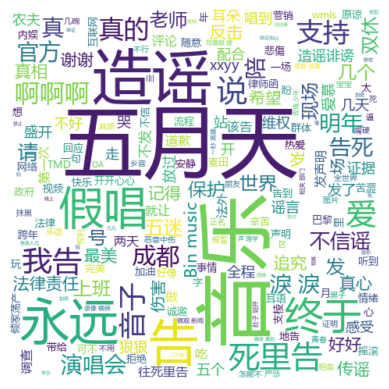

In [210]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import jieba
# 中文分词
text = ' '.join(jieba.cut(str(text_list)))

# 生成对象
img = Image.open("test.jpg") # 打开遮罩图片
mask = np.array(img) #将图片转换为数组
stopwords=[]
with open('stopwords.txt', encoding='utf-8') as stopwords_file:
    contentlist = stopwords_file.readlines()
    for line in contentlist:
        leng=len(str(line))
        stopwords.append(str(line)[0:leng-1])
wc = WordCloud(font_path="msyh.ttc",
               mask=mask,
               width = 1000,
               height = 700,
               background_color='white',
               max_words=200,
               stopwords=stopwords).generate(text)

# 显示词云
plt.imshow(wc, interpolation='bilinear')# 用plt显示图片
plt.axis("off")  # 不显示坐标轴
plt.show() # 显示图片

以下代码用于展示博客的评论情绪分值密度函数。用户可以通过该图表直观的看出指定微博评论区中的情绪倾向。

根据对多条微博的测试发现，在科普类微博评论区中，情绪中等的评论占大多数，原因可能在于科普类微博不太会引起人们的情绪变化，与感性关联度低。

而在争议性微博评论区中，情绪负面的评论则占大多数，这些微博可能引起了观念不同的人们的强烈讨论。

在娱乐圈微博评论区中，情绪正面且分数趋近于1（满分）的评论会占绝大多数。无论该微博的标题是否是争议性的。这可以体现出在娱乐圈微博评论区中，控评现象和粉丝化现象可能十分严重。

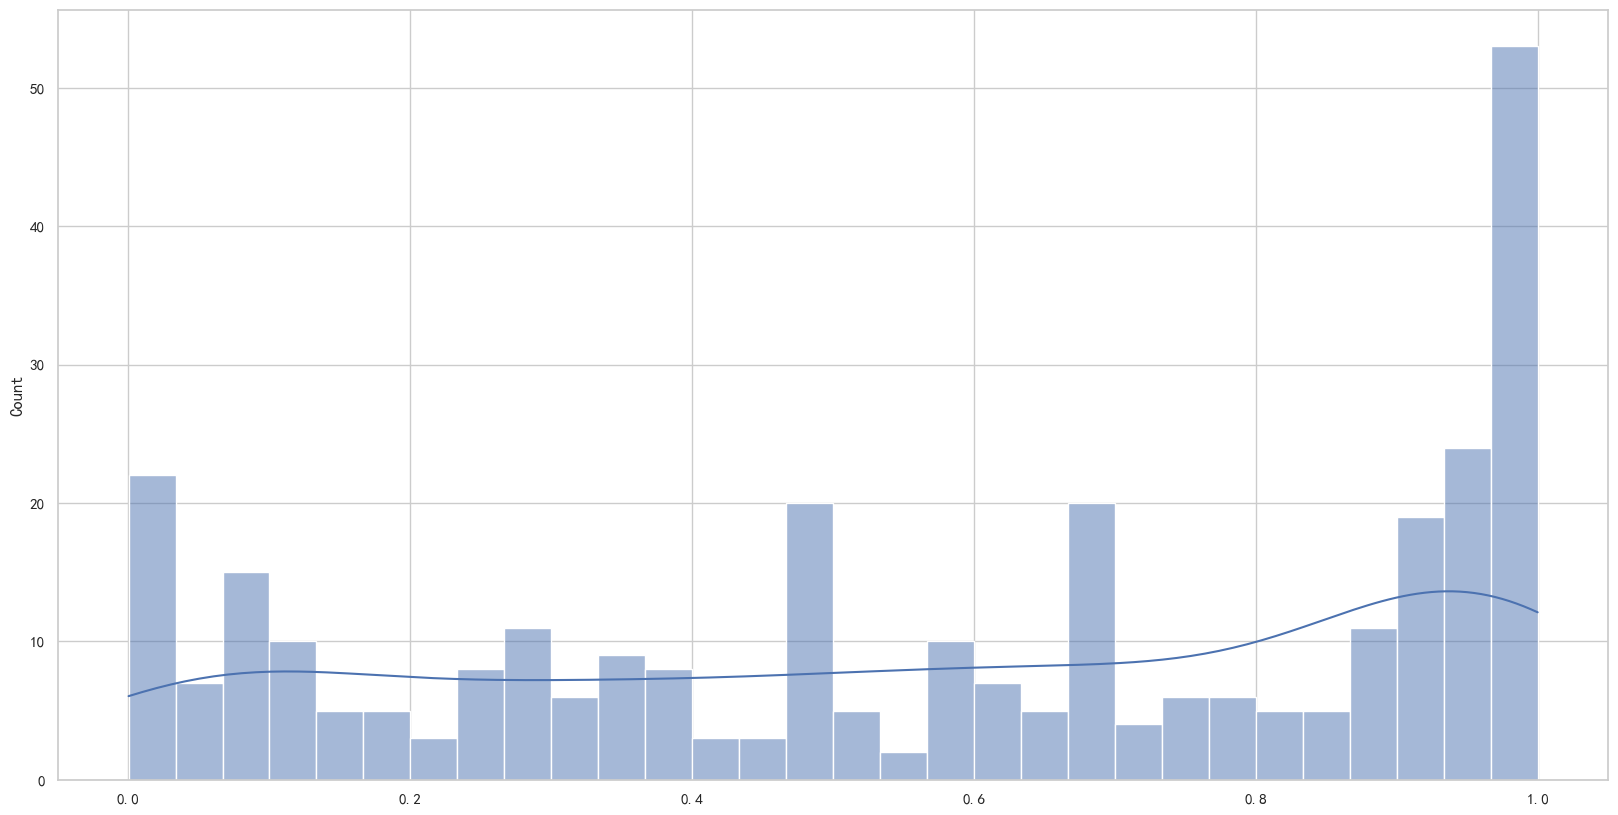

In [211]:

plt.figure(figsize=(20, 10))
# 设置Seaborn样式
sns.set(style="whitegrid",rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False})
sns.histplot(text_score_list,kde=True,bins=30)
plt.show()



以下代码用于展示评论区中男性与女性的比例。

根据对多条微博评论区的男女比例分析，可以发现在娱乐圈相关的微博评论区中的女性数量是多于男性的。一般为男性的1.5~4倍。而在科技相关的微博评论区中男性的数量是多于女性的。

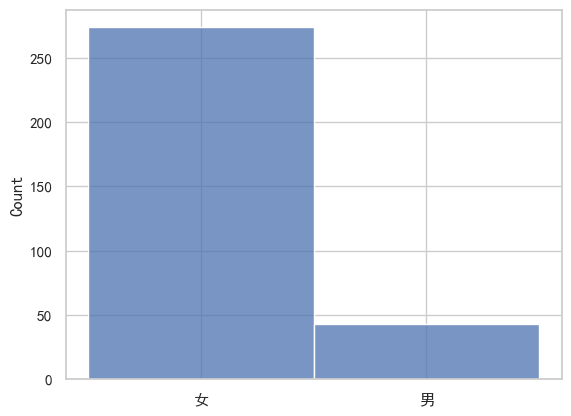

In [212]:
sns.histplot(user_gender_list, binwidth=0.5)
plt.show()

以下代码用于展示男性的评论情绪分值密度函数与女性评论情绪分值密度函数。

通过多条微博测试发现，在非娱乐圈微博评论区中两性的评论情绪分值分布总体都比较相近。在娱乐圈微博评论区中，男性的评论在情绪最低分区域与最高分区域中均具有峰值（但男性评论较少），女性则在最高分区域上具有明显的峰值，是数据的主要组成部分。

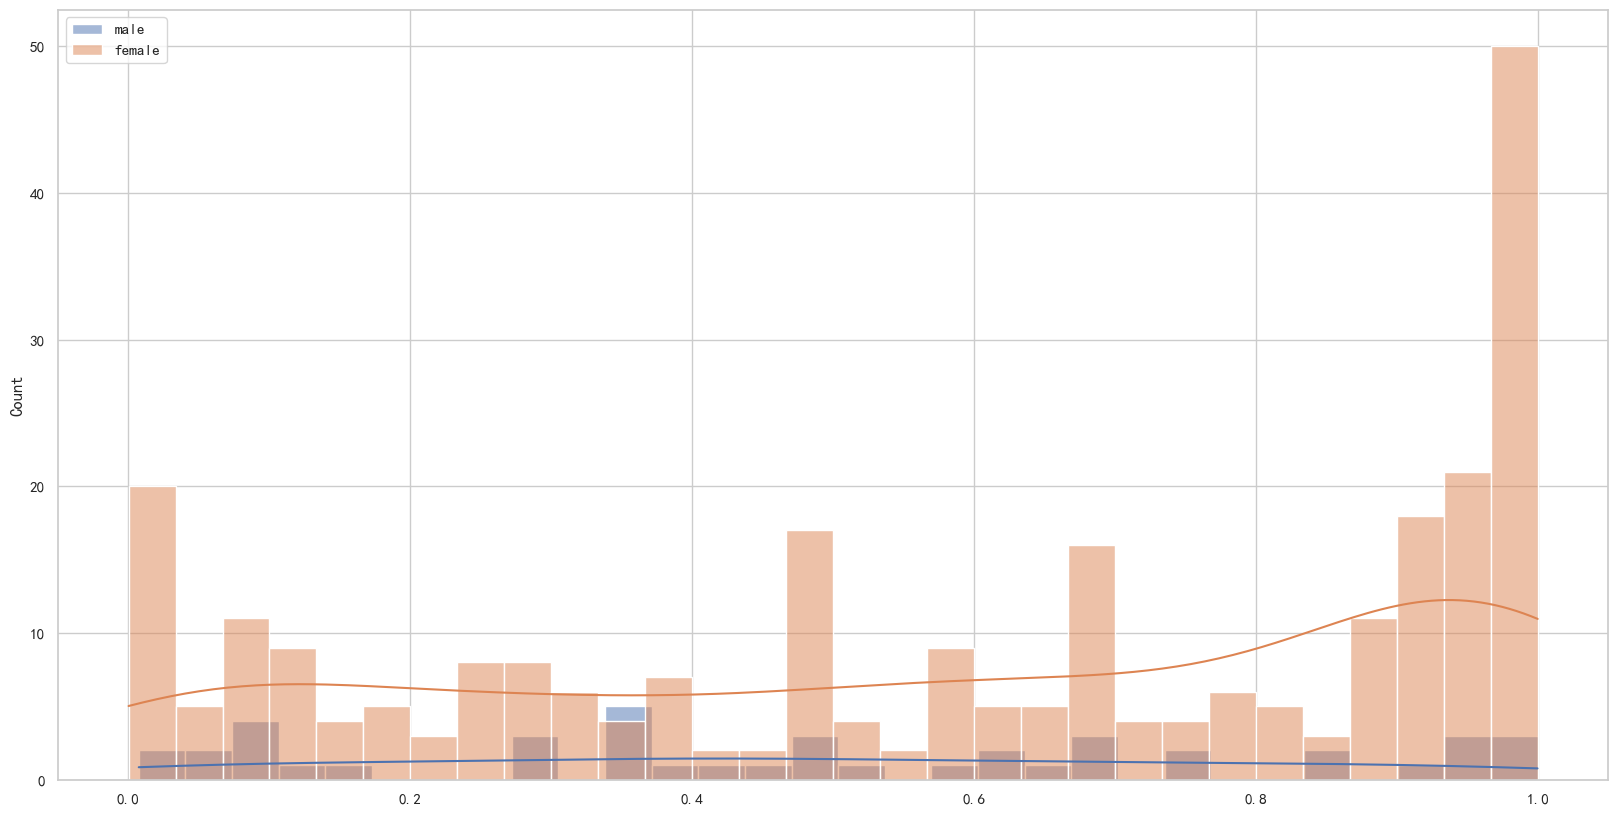

In [213]:
plt.figure(figsize=(20, 10))
sns.histplot(male_score_list,label='male',bins=30,kde=True)
sns.histplot(female_score_list,label='female',bins=30,kde=True)
plt.legend()
plt.show()

以下图表展示了微博对应的评论中评论者粉丝数量与其评论的情绪分值的散点图。用于展示评论区中是否会出现所谓“大V”带动舆论风向或者出现大量小号水军控评等现象。大于一千名粉丝的用户会被统计为一千名。

通过对不同类型微博的粉丝量与评论情绪分值分析发现：娱乐圈相关的微博的情绪分值最高分区的评论绝大多数都是由粉丝量较少的用户组成的。而其他情绪分值分区的用户的粉丝数量比例则明显要平衡许多。这体现出了在娱乐圈相关的微博评论区中，水军或者粉丝控评现象十分明显。

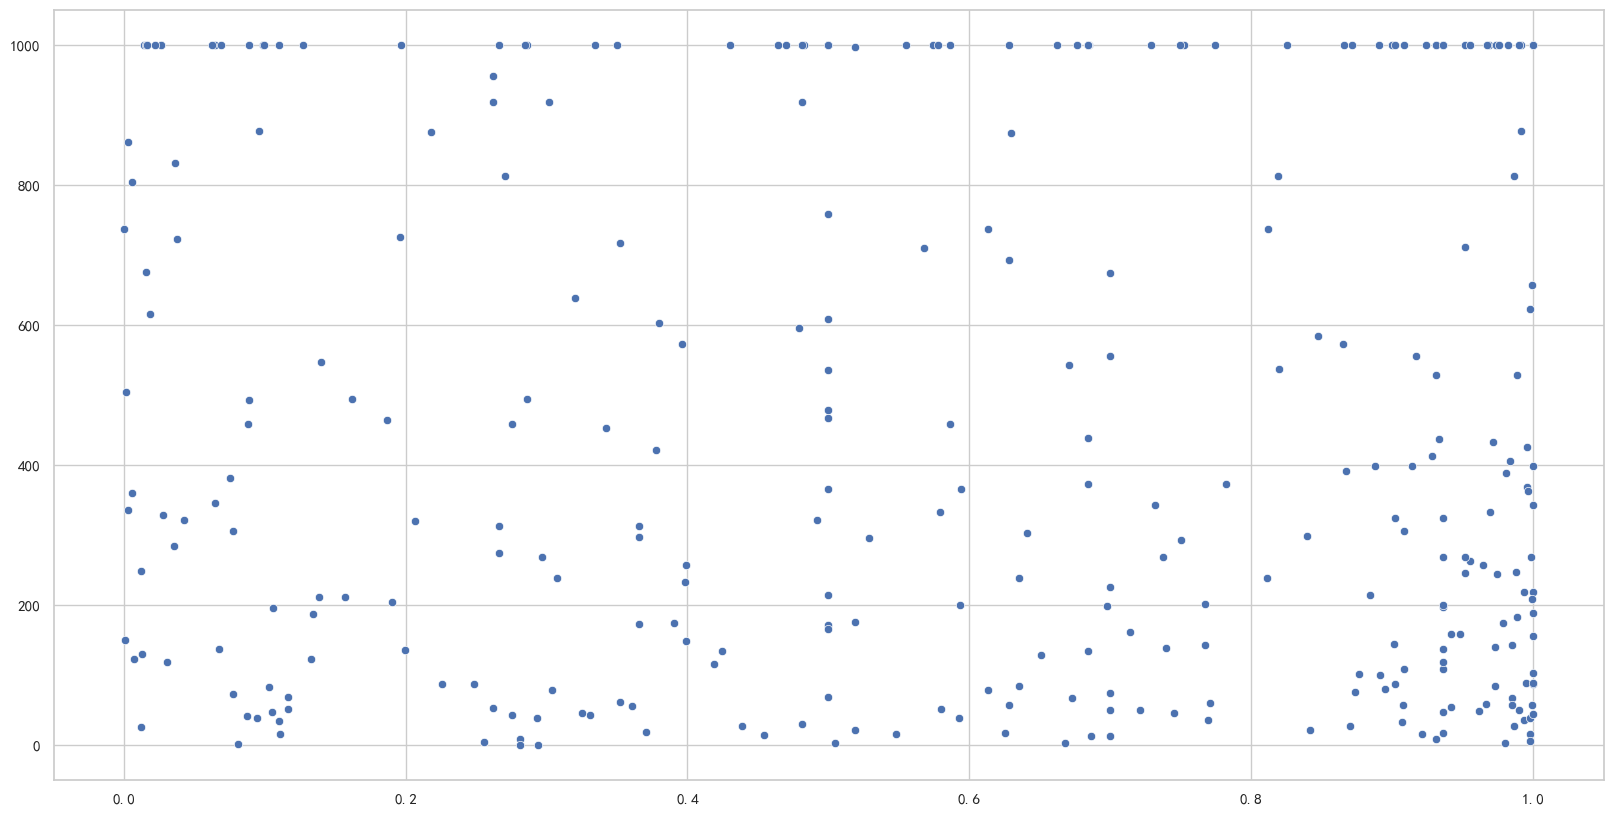

In [214]:
plt.figure(figsize=(20, 10))
length=len(followers_count_list)
for i in range(0,length):
    followers_count_list[i]=min(1000,followers_count_list[i])
sns.scatterplot(x=text_score_list, y=followers_count_list)
plt.show()

以下代码用于展示评论区中不同ip属地的评论的数量。

通过对多条微博的测试发现，广东ip的评论一般都是评论区中最多的。除此之外北京ip的评论也相对较多。

并且，ip的比例与内容也呈现相关性。在一条四川明星丁真的微博评论区中，四川ip的评论会明显的占比最多，而在其他的评论区中四川ip评论一般为广东ip的一半。

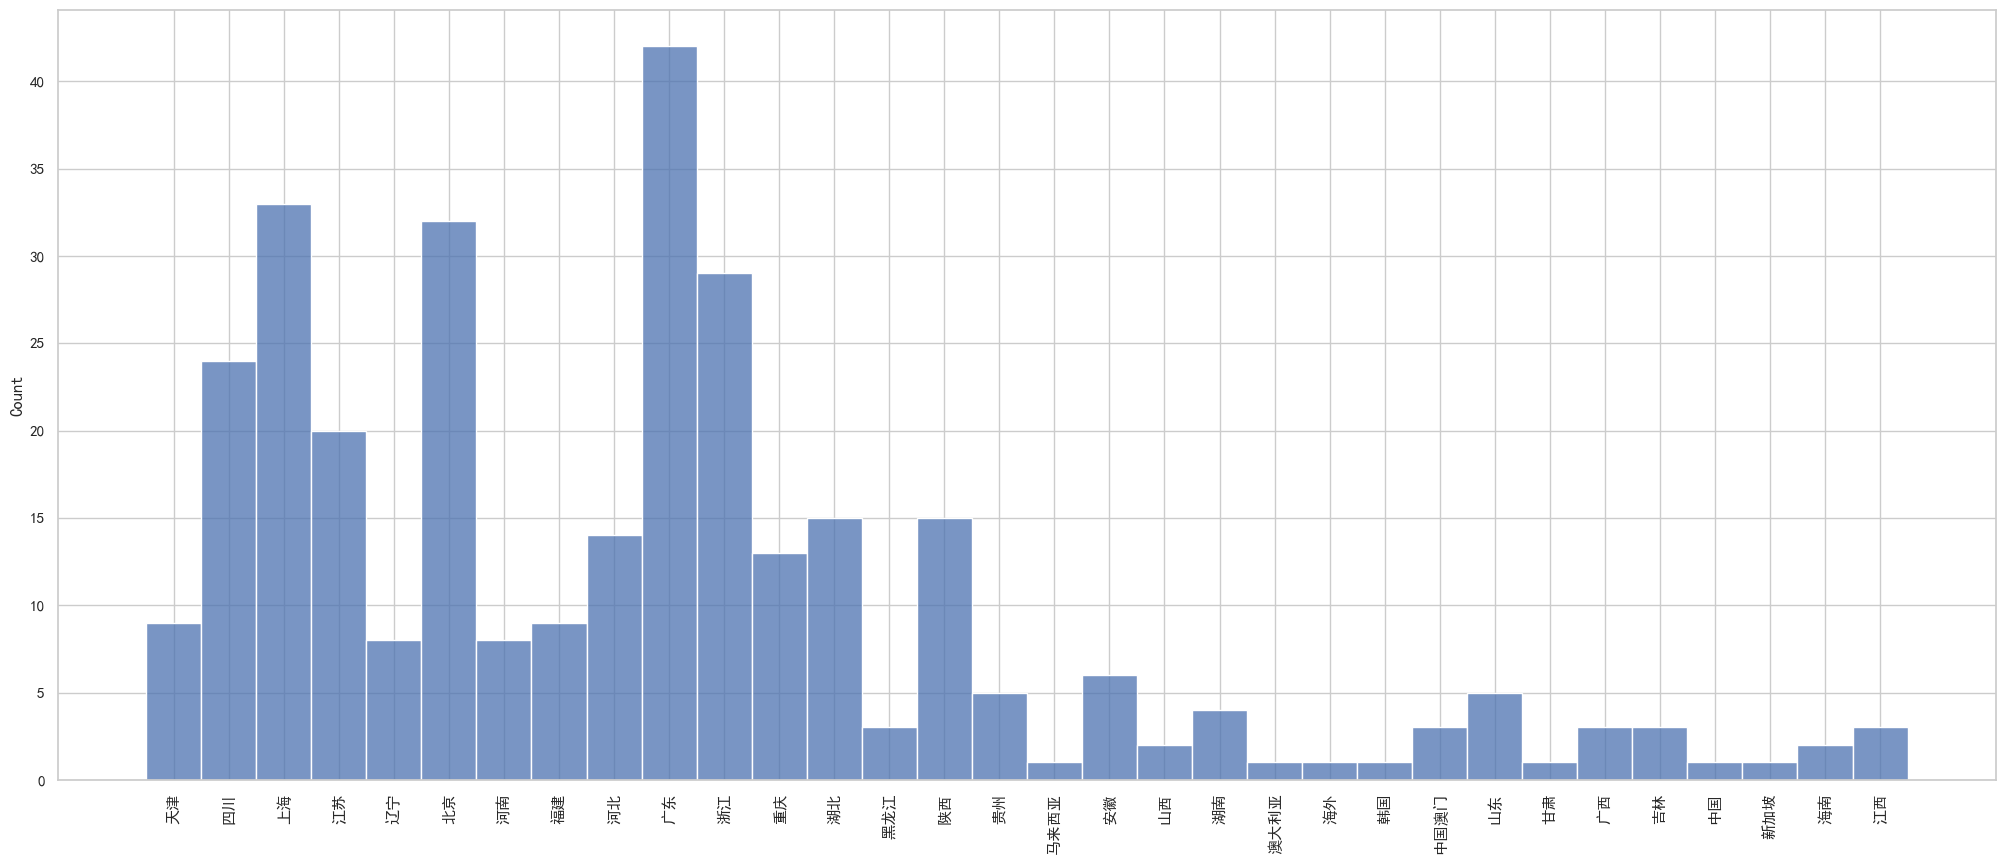

In [215]:
plt.figure(figsize=(25, 10))
sns.histplot(source_list)
plt.xticks(rotation='vertical')
plt.show()

以下代码用于展示评论区中不同ip属地的评论的情绪分值密度函数。若ip属地个数大于5个则选取评论数量前五的ip进行展示。

通过对多条微博的测试发现，不同ip属地的评论情绪分布会有一些变化。比如：在一条争议性娱乐圈评论区中，其他主要ip的最高峰值处在0.8~1.0之间，而北京ip的最高峰值可能会出现在0.2~0.4之间。这可能体现出了由于网络监管力度或者文化影响等原因，北京IP的水军或粉丝比例较少。

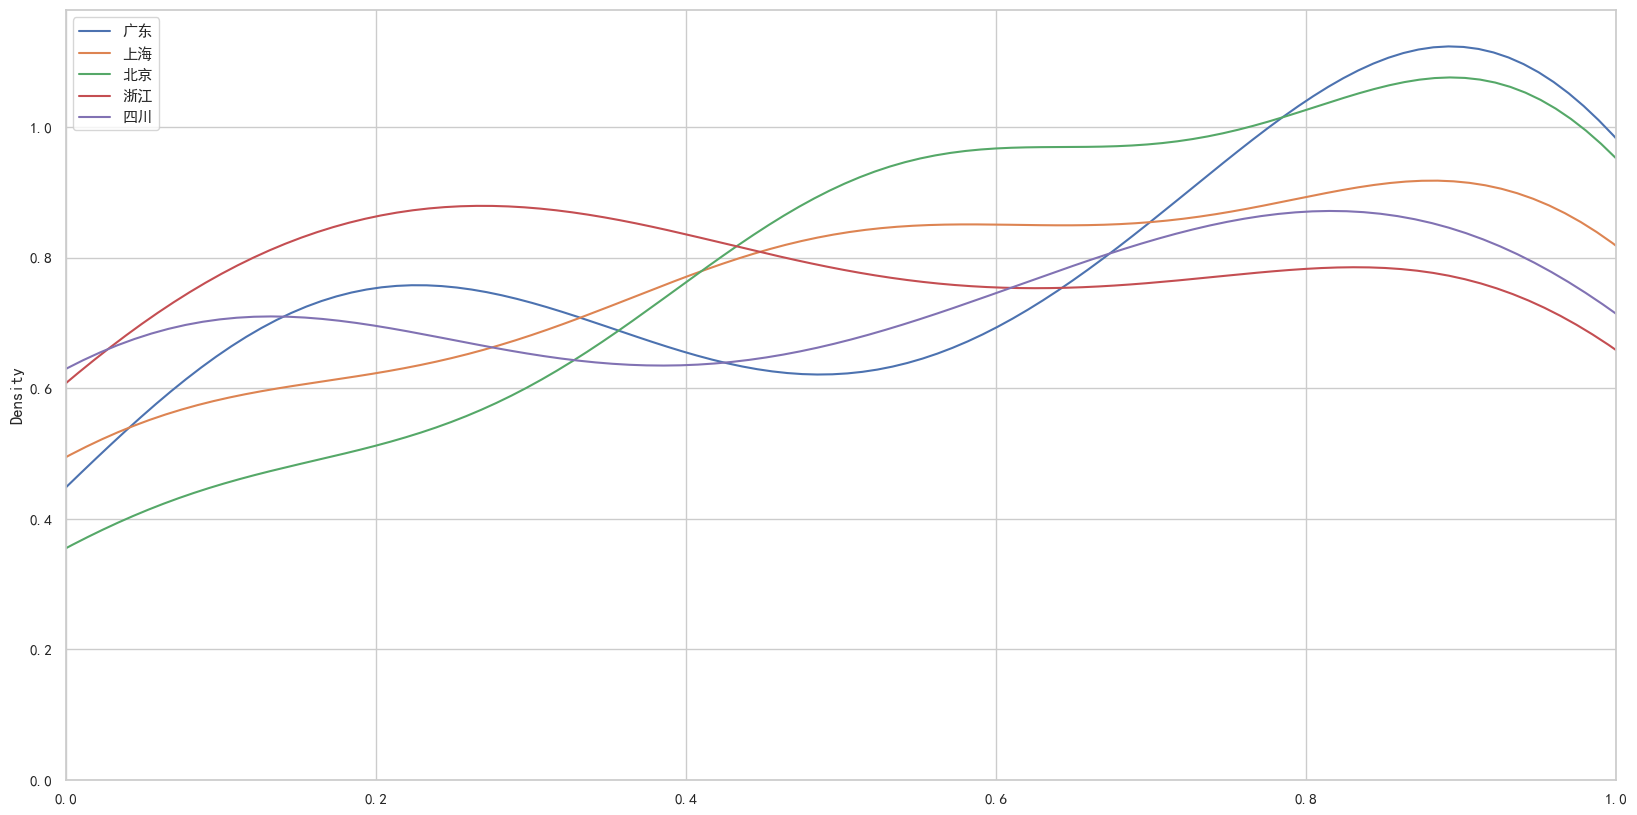

In [216]:
dic=dict()
for i in source_list:
    if(not i in dic):
        dic[i]=0
    dic[i]+=1
num=min(5,len(list(dic)))
lst=sorted(dic.items(),key=lambda d:d[1],reverse=True)
for i in range(0,num):
    lst[i]=lst[i][0]
leng=len(source_list)
dic=dict()
for i in range(0,num):
    for j in range(0,leng):
        if(source_list[j]==lst[i]):
            if (not i in dic):
                dic[i]=list()
            dic[i].append(text_score_list[j])
plt.figure(figsize=(20, 10))
for i in range(0,num):
    sns.kdeplot(dic[i],label=lst[i])
plt.xlim(0,1)
plt.legend()
plt.show()

以下代码用于展示评论区中评论的情绪分值平均值随时间变化的曲线。

对于随着时间出现转折的社会舆论事件微博评论区来说，该曲线可能会出现在某一时间点前后情绪分值平均值骤增或骤降的现象。

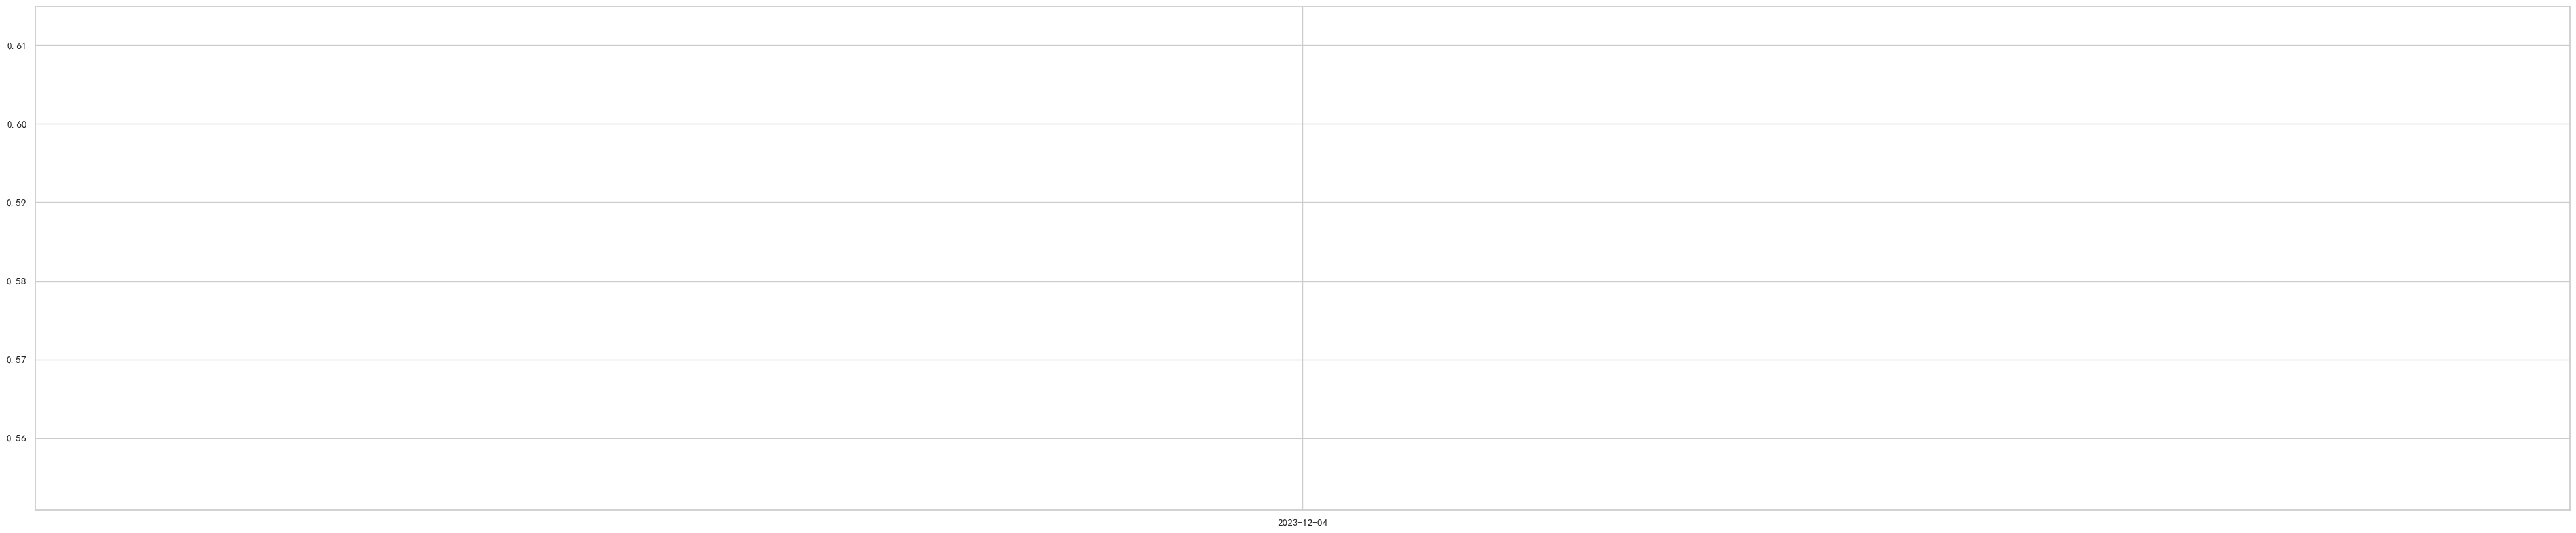

In [217]:
plt.figure(figsize=(50, 10))
dic={}
lst1=list()
lst2=list()
length=len(text_score_list)
for i in range(0,length):
    tmp=time_list[i][0:10]
    if tmp in dic.keys():
        dic[tmp].append(text_score_list[i])
    else:
        dic[tmp]=[]
        dic[tmp].append(text_score_list[i])
lst = sorted(dic.items(),  key=lambda d: d[0], reverse=False)
dic={}
lastOne=0
for i in lst:
    dic[i[0]]=i[1]
for i in list(dic.keys()):
    sum=0
    for j in dic[i]:
        sum+=j
    lst1.append(i)
    lst2.append(sum/len(dic[i]))
sns.lineplot(x=lst1,y=lst2)
#plt.xticks([0,len(lst1)-1,int((len(lst1)-1)/2)])
plt.show()